# Some Fun Visualisations of the Tracked Marine Heatwaves

In [1]:
import xarray as xr
import numpy as np
import dask
from getpass import getuser
from pathlib import Path

import spot_the_blOb.helper as hpc
from spot_the_blOb.plotter import specify_grid, PlotConfig

In [2]:
# Start Dask Cluster
client = hpc.StartLocalCluster(n_workers=32, n_threads=1)

Memory per Worker: 15.74 GB
Hostname is  l40235
Forward Port = l40235:8787
Dashboard Link: localhost:8787/status


In [3]:
# Directories
scratch_dir = Path('/scratch') / getuser()[0] / getuser()

fpath_ckdtree = scratch_dir / 'grid_files' / 'ckdtree' / 'rectgrids'
fpath_tgrid = scratch_dir / 'grid_files' / 'fpath_tgrid.zarr/'
MHW_dataset = scratch_dir / 'mhws' / 'MHWs_tracked_unstruct_480days.zarr'

In [4]:
# Define the Structure of the Unstructured Grid
specify_grid(grid_type='unstructured', fpath_ckdtree=fpath_ckdtree)

In [5]:
# Import Tracked MHW DataSet
blobs_ds = xr.open_zarr(str(MHW_dataset), chunks={})
blobs_ds

<xarray.Dataset> Size: 29GB
Dimensions:       (ID: 594, time: 480, ncells: 14886338, component: 2,
                   sibling_ID: 4)
Coordinates:
  * ID            (ID) int32 2kB 1 2 3 4 5 6 7 8 ... 588 589 590 591 592 593 594
    lat           (ncells) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
    lon           (ncells) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
  * time          (time) datetime64[ns] 4kB 2002-04-11T23:59:00 ... 2003-08-0...
Dimensions without coordinates: ncells, component, sibling_ID
Data variables:
    ID_field      (time, ncells) int32 29GB dask.array<chunksize=(1, 14886338), meta=np.ndarray>
    area          (time, ID) float32 1MB dask.array<chunksize=(1, 594), meta=np.ndarray>
    centroid      (component, time, ID) float32 2MB dask.array<chunksize=(2, 1, 594), meta=np.ndarray>
    global_ID     (time, ID) int32 1MB dask.array<chunksize=(1, 594), meta=np.ndarray>
    merge_ledger  (time, ID, sibling_ID) int32 5MB dask.array<chunksize=(1, 594, 4), meta=np.ndarray>
    presence      (time, ID) bool 285kB dask.array<chunksize=(1, 594), meta=np.ndarray>
    time_end      (ID) datetime64[ns] 5kB dask.array<chunksize=(480,), meta=np.ndarray>
    time_start    (ID) datetime64[ns] 5kB dask.array<chunksize=(480,), meta=np.ndarray>
Attributes: (12/13)
    N_blobs_final:               593
    N_blobs_prefiltered:         27067
    R_fill:                      32
    T_fill:                      2
    accepted_area_fraction:      0.8216272149540188
    allow_merging:               1
    ...                          ...
    area_threshold (cells):      21200.600000000035
    multi_parent_merges:         46
    nn_partitioning:             1
    overlap_threshold:           0.5
    preprocessed_area_fraction:  0.7430769401996683
    total_merges:                726

In [6]:
# Extract the MHW ID Field
blobs = blobs_ds.ID_field
blobs

<xarray.DataArray 'ID_field' (time: 480, ncells: 14886338)> Size: 29GB
dask.array<open_dataset-ID_field, shape=(480, 14886338), dtype=int32, chunksize=(1, 14886338), chunktype=numpy.ndarray>
Coordinates:
    lat      (ncells) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
    lon      (ncells) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
  * time     (time) datetime64[ns] 4kB 2002-04-11T23:59:00 ... 2003-08-03T23:...
Dimensions without coordinates: ncells

In [7]:
data = blobs.isel(time=slice(20,26))
data = data.where(data>0)
config = PlotConfig(plot_IDs=True)


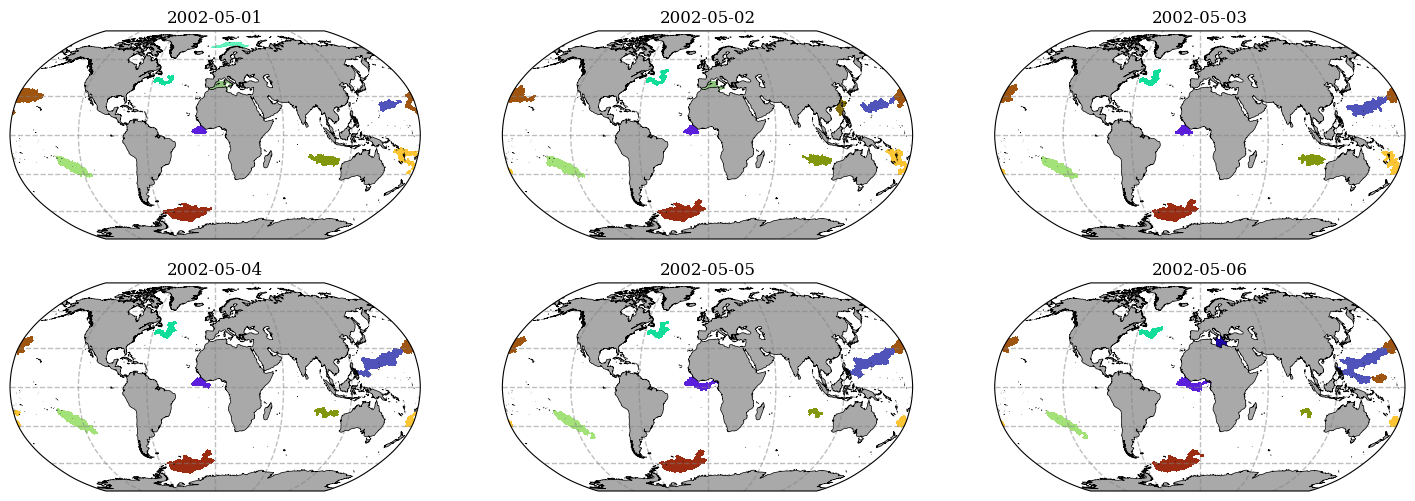

In [8]:
data.xplot.multi_plot(config, col='time', col_wrap=3);

In [ ]:
data = blobs
data = data.where(data>0)

plot_dir = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'plots'

config = PlotConfig(plot_IDs=True)
data.xplot.animate(config, plot_dir=plot_dir)

## Make a Nice Blobby Movie
N.B.: Making `dask`-powered movies using `pplot_mov()` cannot be threaded !

In [ ]:
plot_dir = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'plots'
time_slice = slice('2024-01-01', '2026-01-01')

In [ ]:
blobs_subset = blobs.sel(time=time_slice)
blobs_subset = blobs_subset.where(blobs_subset > 0)
blobs_subset.plotter.pplot_mov(plot_dir=plot_dir, plot_IDs=True)

In [ ]:
%%HTML
<video width="640" height="480" controls>
    <source src="./plots/movie_ID_field.mp4" type="video/mp4">
    Your browser does not support the video tag.
</video>

## Plot Consecutive Days of Blobby Shapes

In [ ]:
blobbys = blobs.sel(time=slice('2025-01-01', '2025-01-06'))
blobbys = blobbys.where(blobbys>0) 
fig, ax = blobbys.plotter.pplot_col(plot_IDs=True, col_wrap=3, show_colorbar=False)

## Plot some Blobby Shapes (1 Each Month)

In [ ]:
blobs_day1 = blobs.sel(time=slice('2025-01-01', '2025-12-31')).resample(time='MS').first()
blobs_day1 = blobs_day1.where(blobs_day1>0)
fig, ax = blobs_day1.plotter.pplot_col(plot_IDs=True, col_wrap=3, show_colorbar=False)


## Global Blob Frequency

In [ ]:
event_frequency = (blobs > 0).astype(float).mean('time')
fig, ax = event_frequency.plotter.pplot(var_units='MHW Frequency', cmap='hot_r', cperc=[0,96])

## Find & Plot a Few of the Longest Events

In [ ]:
events_duration = blobs_ds.time_end - blobs_ds.time_start
longest_events = events_duration.sortby(events_duration, ascending=False).ID

for ID in longest_events[:10].values:
    print(f"ID: {ID:<6}   Start Day: {blobs_ds.time_start.sel(ID=ID).dt.strftime('%Y-%m-%d').values}  -->  Duration: {events_duration.sel(ID=ID).dt.days.values:<4} days")

In [ ]:
long_blobs = blobs == (longest_events[:9]).chunk({'ID':1})
long_blobs_local_duration = (long_blobs > 0).sum('time')

fig, ax = long_blobs_local_duration.plotter.pplot_col(col='ID', col_wrap=3, var_units='Duration (days)', cmap='hot_r', cperc=[0, 100])

## Time-Series Plot of Events Area

In [ ]:
events_areas = blobs_ds.area * 1.0e5/16.0 # km^2 (very rough estimate, since "area" here is in units of 0.25x0.25 degree grid cells...)

area_mean = events_areas.mean('ID').resample(time='ME').mean()

area_10 = events_areas.reduce(np.nanpercentile, q=10, dim='ID').resample(time='ME').mean()
area_90 = events_areas.reduce(np.nanpercentile, q=90, dim='ID').resample(time='ME').mean()

plt.figure(figsize=(15, 6))
area_mean.plot(label='Mean Area', color='k', lw=2)
plt.fill_between(area_mean.time.values, area_10, area_90, alpha=0.5)
#plt.yscale('log')
plt.ylim([0, 8e7])
plt.ylabel('Rough Event Area [km^2]')


## Hovmüller Plot of MHW Monthly Frequency vs Latitude

In [ ]:
spatial_presence = (blobs > 0).mean(dim='lon').resample(time='ME').mean()

fig, ax = plt.subplots(figsize=(15, 6))
im = spatial_presence.plot(ax=ax, cmap='hot', x='time',
    cbar_kwargs={
        'label': 'MHW Presence Frequency',
        'extend': 'both'})

ax.set_xlabel('Time')
ax.set_ylabel('Latitude')
ax.grid(True, linestyle='--', alpha=0.6)


## Seasonal Cycle of MHW vs Latitude

In [ ]:
spatial_presence_seasonal = (blobs > 0).mean(dim='lon').groupby('time.dayofyear').mean()

fig, ax = plt.subplots(figsize=(15, 6))
im = spatial_presence_seasonal.plot(ax=ax, cmap='hot', x='dayofyear',
    cbar_kwargs={
        'label': 'MHW Seasonal Frequency',
        'extend': 'both'})

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
month_positions = np.cumsum([0] + days_per_month[:-1]) + 15

ax.set_xticks(month_positions)
ax.set_xticklabels(months)
ax.set_xlabel('Month')
ax.set_ylabel('Latitude')
ax.grid(True, linestyle='--', alpha=0.6)
